<a href="https://colab.research.google.com/github/Vibertexs/Tensorflow-Projects/blob/main/Fashion_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspirit AI Notebook Made During Course

In [ ]:
import tensorflow as tf
!pip install imageio
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow_datasets as tfds
from mpl_toolkits.axes_grid1 import ImageGrid
from itertools import islice
from IPython import display


def show_dataset_examples(ds):
  grid = ImageGrid(plt.figure(), 111, nrows_ncols=(4, 4), axes_pad = 0.1)
  for index, img in islice(enumerate(ds),16):
    grid[index].imshow((img+1)/2, cmap = 'Greys')
  plt.show()


checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

def train(dataset, epochs):

  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
    
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  
def scale_and_show(img):
  plt.imshow(np.array(img[:,:,0]), cmap = "Greys")

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      scale_and_show(predictions[i])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show() 

# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
print (train_images.shape) 

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)


In [ ]:
print (train_images.shape)
train_images_reshaped = np.expand_dims(train_images, 3)
print (train_images_reshaped.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [ ]:
print (train_images_reshaped.min(), train_images_reshaped.max())
train_images_scaled = (train_images_reshaped - 127.5)/127.5
print (train_images_scaled.min(), train_images_scaled.max())

0 255
-1.0 1.0


In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
IMG_SIZE = 28
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
generator_lr = .0001
discriminator_lr = .0001

In [ ]:
def make_discriminator_model():

    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28,28,1]))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model 

In [ ]:
discriminator = make_discriminator_model()
print (discriminator.summary())

decision = discriminator.predict(train_images_scaled[:1])
print()
print ("Prediction for image from training data:", decision)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [ ]:

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) 

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

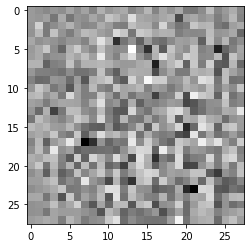

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)        

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

scale_and_show(generated_image[0])
plt.show()

print(generator.summary())

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(disc_fake_output):
    loss = cross_entropy(tf.ones_like(disc_fake_output), disc_fake_output)
    return loss 

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(generator_lr)
discriminator_optimizer = tf.keras.optimizers.Adam(discriminator_lr)

#We'll reuse input to the generator in our GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim]) 

#Packaging up our training images as a Dataset object
train_dataset = tf.data.Dataset.from_tensor_slices(train_images_scaled).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      #Make images:
      generated_images = generator(noise, training=True)

      #Get the discriminator's output:
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      #Calculate each network's loss:
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    #Update each network's weights to (hopefully) reduce the loss next time:
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


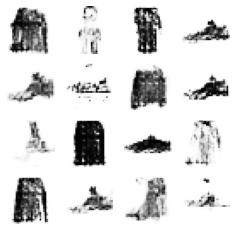

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Acknowledgements: Parts of this notebook were adapted from https://www.tensorflow.org/tutorials/generative/dcgan, which includes license information. Check out more GAN tutorials at that link!
